In [1]:
import numpy as np
import xsimlab as xs
#from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = [15, 10]

# I'll use this notebook to put down ideas I have during the writing process

# right now it is just very rough ideas (and stupid ideas), I'll work them out to another more generalistic prototype, where components can be placed in different "Physical Environments" and behave differently

## current thought road block:
### how can i update the state of a component,in the physical environment (which collects all components via xs.group())?



will need to get coding to find out

In [ ]:
okay another idea:
    
    this could be done by having a generic "ForcingParameter" within each component, or as a separate process
    
    because, it should return a default value, if not specified. But if it has been changed in model setup, it should return the new parameter.

xs.create_setup(
    ...
    input_vars={
        'P__num':4,
        'P__ForcingParameter': {'mixing':0.3}
    
        'Physics__mixing':0.2  # this would be the default parameter, for all components, that have no specific value defined

    }
)

# New ideas for solving without explicit time steps:

how about simply adding another process, that assembles ALL state variables, and ALL fluxes, and takes the time range as input and computes the integrated model output similarly to how Benoît did it in the npzd_xsimlab.ipynb!

then the solving method could be added to the model if desired, and the model input / create setup would decide if that is used! (everything happening in initialize time_step, no run_steps)

for that there still needs to be a way to decipher the fluxes from the run_step argument of other fluxes
or a need to define fluxes as any_object instead of steps?


In [1]:
so the computing step, and the actually flux (function) would be separated?

Object `separated` not found.


In [2]:
so the computing step, and the actually flux (function) would be separated

SyntaxError: invalid syntax (<ipython-input-2-2b54f8048eb0>, line 1)

## Older Notes:

- the grouping variables are well suited for the kind of flexibility I had envisioned

the way it can be set up:

component:
    collects forcing fluxes
    collects component fluxes
    
    calculates state based on forcing fluxes & component fluxes
    (this could also be "mixing fluxes" in slab setting, etc.)
    
    calculation of state can be modified by subclassing forcingflux calcualtion in subclass of component.
    
    
phytoplankton(component):
    collects phytoplankton fluxes
    collects phytoplanktongrowth modifiers
    
    calculates state based on phytoplanktongrowth modifiers and fluxes
    then super(component).run_step()
    

mixing(forcingflux):
    takes foreign MLD
    
    calculates mixing flux, excluding biomasses. groups='forcing_flux'
    
    # to affect once component differently (parameterisation), define here another d_flux, that cancels out forcing flux, and calculates specific one.
    #  but there must be a more elegant way..., it should be stored and calculated with the component, i.e. that the forcing flux is there changed. Problem is that this is just what all components share, so not same organisational level as within components.
    # why can't it be calculated within another higher level component, and then passed down?
    # this would be the physical environment! it would xs.group all components, and then calculate forcings on them? WELL, it could calculate the  part of the fluxes without the parameter! and then within the component, the forcing_fluxes get multiplied by the parameters to add to the state.
    # this somehow feels convoluted as well, then each physical environment would call for different components. Why aren't the forcing fluxes simply treated the same as component fluxes? because that means writing it out for each component. But how about, actuall having both, like generic components, that take forcing flux, and then ungener... same problem.
    
    # so it actually works, by having the forcing process, for example calculate all P fluxes, all Z fluxes (i.e. these share one flux), then one generic mixing term for D, that would be added to each new component, when initializing multiple Zooplankton for example, they would inherit the Z mixing term, P respectively.. this means, if people modify the model enough, they might have to add a new forcing flux to the "physical environment".
    
SlabModel(PhysicalEnvironment):
    contains Mixing function
    
    calculates N, P, Z ,D fluxes, specifically each. This is for each type of component, a specific flux, new components need to be based on classes that contain these, when using this model.

lightharvesting(flux):

    
    

In [ ]:
So interestingly, this connundrum, puts the one issue to the very front.

that is parameterisation, like each model component, inherits certain parameters from the phyiscal environment, and from processes.

like they make it necessary to implement in each subclass.

but this would need to be different, generic Phytoplankton, or N components
and the parameters only need to be supplied, if a certain component calls for them. 

how could this be done??

In [ ]:
both problems are quite related!

maybe collect all components, and then the fluxes for that array are calculated within the phyiscal process! again, answer is: make em' arrays
    
    like, that, each component can supply it's parameter to the array, if it is not specified in component, it is either 0 or a default one!
    
this would actually work! nice :) 
    
    
Physical Environment:
    collects all component states
    collects all forcing related parameters as arrays in the same order, but try_catch style, if missing to 0 or default
    
    calculates component fluxes, and updates their states.. is that possible? would be powerful, damn


# Components
Processes defining and tracking the state variables of our model

In [3]:
@xs.process
class Component:
    """
    Each component of the ecosystem represents a scalar or array of state variables that are defined by the same fluxes.
    Multiple state variables can encode different behaviour through parameters, that are kept as arrays of the same dimension as the component.
    """
    num = xs.variable(dims=(),intent='in', description='number of this component (i.e. number of state variables)')

    @xs.runtime(args="step_delta")
    def run_step(self, dt):
        self.delta = sum((v for v in self.fluxes)) * dt  # multiply by time step
    
    @xs.runtime(args="step_delta")
    def finalize_step(self, dt):
        self.state += self.delta * self.state
        
    
@xs.process
class Nutrient(Component):
    """
    The Nutrient component so far only supports one instance, however more nutrients could be added, by instantiating multiple Nutrient components. (This also makes more ecological sense.)
    """
    N = xs.index(dims='N')
    component_label = xs.variable(default='N', groups='component-label', static=True)
    
    fluxes = xs.group('n_flux')
    state = xs.variable(dims='N', intent='inout', groups = 'state-variable', description='component array', attrs={'units': 'µM N'})

    # PARAMETERS / INPUTS
    num = xs.variable(default=1, static=True, description='number of nutrients (1 by default)')
    
    def initialize(self):
        self.time = 0
        self.N = np.array([f"{self.component_label}-{i+1}" for i in range(self.num)])
            
@xs.process
class Phytoplankton(Component):
    """
    The Phytoplankton component allows for multiple state variables to be instatiated along the 'P' dimension.
    The parameter 'halfsat' is initialized in the ModelSetup process, and describes the half-saturation constant of nutrient uptake for each Phytoplankton state variable along dimension 'P'. 
    (Note: in this simplified model nutrient uptake = growth, also described as the Monod equation. Any ingested nutrient is directly converted to biomass.)
    
    Parameters are stored in arrays the same dimensionality as the states, so that each "Phytoplankton" can have a different parameterization. The initialisation of the parameter arrays is handled in the ModelSetup class.
    """
    P = xs.index(dims='P')
    component_label = xs.variable(default='P', groups='component-label', static=True)
    
    fluxes = xs.group('p_flux')
    state = xs.variable(dims='P', intent='inout', groups = 'state-variable', description='component array', attrs={'units': 'µM N'})
    
    # PARAMETERS / INPUTS
    halfsat = xs.variable(intent='in', dims='P', groups='parameters', attrs={'units': 'µM N'})
    mortality = xs.variable(intent='in', dims='P', groups='parameters', attrs={'units': 'd-1'})
    
    def initialize(self):
        self.time = 0
        self.P = np.array([f"{self.component_label}-{i+1}" for i in range(self.num)])

# Fluxes
Processes affecting the state variables. Each flux process is a term in the system of differential equations that underly this model.

In [4]:
@xs.process
class NutrientUptake:
    """
    Phytoplankton growth, as a function of nutrient concentrations and the half-saturation constants.
    
    Two fluxes are defined, one substracting from Nutrient, the other adding to Phytoplankton
    """
    growth = xs.variable(
        dims='P',
        intent='out',
        groups=['p_flux'],
        description='phytoplankton growth, under light & nutrient limitation',
        attrs={'units': 'µM N d-1'}
    )
    
    uptake = xs.variable(
        dims='N',
        intent='out',
        groups=['n_flux'],
        description='sum of all phytoplankton growth',
        attrs={'units': 'µM N d-1'}
    )
    
    N = xs.foreign(Nutrient, 'state', intent='in')
    P = xs.foreign(Phytoplankton, 'state', intent='in')
    P_halfsat = xs.foreign(Phytoplankton, 'halfsat', intent='in')
    
    def run_step(self):
        nutrient_uptake = self.N / (self.P_halfsat + self.N) * self.P
        self.growth = np.array(nutrient_uptake, dtype='float64')
        self.uptake = np.array(- sum(nutrient_uptake), dtype='float64')

        
@xs.process
class PhytoMortality:
    """
    Phytoplankton mortality at a linear rate.
    
    The flux is negative
    """
    mortality = xs.variable(
        dims='P',
        intent='out',
        groups=['p_flux'],
        description='phytoplankton growth, under light & nutrient limitation',
        attrs={'units': 'µM N d-1'}
    )
    
    P = xs.foreign(Phytoplankton, 'state', intent='in')
    P_mortality = xs.foreign(Phytoplankton, 'mortality', intent='in')
    
    def run_step(self):
        self.mortality = - sum(np.array([0.1], dtype='float64')) * self.P

# Physical Environment

It should:
- serve as an input point for forcing (can be accessed by other fluxes from here)
- collect all components in array
- collect all specific forcing params as array (depending on supplied vars, otherwise default var)

the calculation of forcing needs to be matrix numpy FAST
and ideally, I can aggregate PhysicalEnv component array, into giant matrix! for 3D.. start with 1D

Parent Class: PhysicalEnvironment

subclass Slab


In [16]:
@xs.process
class PhysicalEnvironment:
    """
    parent class for PE's
    """
    
    components = xs.group('state-variable')
    forcing = xs.variable(intent='out')
    
    
@xs.process
class Slab(PhysicalEnvironment):
    """
    subclass containing specific slab fluxes and calcs
    """
    
    def initialize(self):
        print(list(self.components))
        self.forcing = 2

where can I start?
can I aggregate all fluxes here, and apply in a matrix wise fashion? 

also needs to handle Forcings!
Forcing should have one basic parent class, and then subclasses to the type of forcing (i.e. MLD), the subsubclass initialized with the model is the one that actually supplies the forcing used, interpolated etc.


SO: basic structural properties include:
- have one dimension for each component (i.e. multiple P)
- have another dimension for each "model instance" within the specific PhysEnv.. this needs to be clearly labeled and callable from other processes

processes need to act at some level.
processes need to take all the parameters within dimension one into account when calcualting
and there there could be a higher level of processes that acts on the model instance array

and one higher than that, that is exchanges between PhysEnvs


In [17]:
@xs.process
class NutrientSource:
    """
    Chemostat constant nutrient inflow from one direction
    
    
    """
    supply = xs.variable(
        dims='N',
        intent='out',
        groups=['n_flux'],
        description='sum of all phytoplankton growth',
        attrs={'units': 'µM N d-1'}
    )

    N = xs.foreign(Nutrient, 'state', intent='in')
    nutrient_influx = xs.variable(intent='in', groups='parameters', attrs={'units': 'µM N d-1'})
    
    def run_step(self):
        self.supply = np.array([self.nutrient_influx], dtype='float64')
        
@xs.process
class Flow:
    """Outflux of N and P"""
    N_outflux = xs.variable(
        dims='N',
        intent='out',
        groups=['n_flux'],
        description='outflux of N',
        attrs={'units': 'µM N d-1'}
    )
    P_outflux = xs.variable(
        dims='P',
        intent='out',
        groups=['p_flux'],
        description='outflux of P',
        attrs={'units': 'µM N d-1'}
    )
    
    flowrate = xs.variable(intent='in', groups='parameters')
    
    P = xs.foreign(Phytoplankton, 'state', intent='in')
    N = xs.foreign(Nutrient, 'state', intent='in')
    
    #@xs.runtime(args='step_delta')
    def run_step(self):
        self.N_outflux = - self.flowrate * self.N 
        self.P_outflux = - self.flowrate * self.P 

# Model setup
processes that initialize model parameters and state variables from user input, to simplify the user interface

In [18]:
@xs.process
class ModelSetup:
    """
    Process needs to be inherited by another class, that initializes all variables and parameters
    """
    # Component setup
    P_num_out = xs.foreign(Phytoplankton, 'num', intent='out')    
    P_init = xs.foreign(Phytoplankton, 'state', intent='out')
    N_init = xs.foreign(Nutrient, 'state', intent='out')
    
    # Phytoplankton parameters
    P_halfsat = xs.foreign(Phytoplankton, 'halfsat', intent='out')
    P_mortality = xs.foreign(Phytoplankton, 'mortality', intent='out')


@xs.process
class ChemostatSetup(ModelSetup):
    """
    Sets up necessary parameters and inputs for the Chemostat Model
    """
    # inputs
    P_num = xs.variable(intent='in', static=True, description='number of Phytoplankton')
    P_initVal = xs.variable(intent='in', description='initial Phytoplankton biomass')
    halfsat_min = xs.variable(intent='in', static=True, description='minimum value half-saturation constant of nutrient uptake for P')
    halfsat_max = xs.variable(intent='in', static=True, description='maximum half-saturation constant of nutrient uptake for P')
    mortality = xs.variable(intent='in', static=True, description='mortality rate of P')
    N_initVal = xs.variable(intent='in', static=True, description='initial Nutrient concentration')

    
    def initialize(self):
        self.P_num_out = self.P_num
        
        self.P_init = np.array([self.P_initVal for i in range(self.P_num)], dtype='float64')
        
        # there is only one nutrient in the current setup:
        self.N_init = np.array([self.N_initVal], dtype='float64')
        
        # halfsat parameter is initiated as a linearly spaced array between the given min and max values
        self.P_halfsat = np.linspace(self.halfsat_min, self.halfsat_max, self.P_num, dtype='float64')
        
        # mortality is the same value for each phytoplankton in the current setup
        self.P_mortality = np.array([self.mortality for i in range(self.P_num)], dtype='float64')

In [19]:
chemostat = xs.Model(
    {
        # PhysEnv
        'PE':Slab,
        # model setup
        'ChemostatModelSetup':ChemostatSetup,
        # components
        'N':Nutrient, 
        'P':Phytoplankton, 
        # flows
        'N_Uptake':NutrientUptake,
        'P_Mortality':PhytoMortality,
        'N_source':NutrientSource,
        'Flow':Flow
    }
)

In [20]:
chemostat

<xsimlab.Model (8 processes, 11 inputs)>
ChemostatModelSetup
    mortality           [in] mortality rate of P
    N_initVal           [in] initial Nutrient concentration
    P_num               [in] number of Phytoplankton
    halfsat_min         [in] minimum value half-saturation constant...
    halfsat_max         [in] maximum half-saturation constant of nu...
    P_initVal           [in] initial Phytoplankton biomass
PE
Flow
    flowrate            [in]
N_source
    nutrient_influx     [in]
N_Uptake
N
    num                 [in] number of nutrients (1 by default)
    component_label     [in]
P_Mortality
P
    component_label     [in]

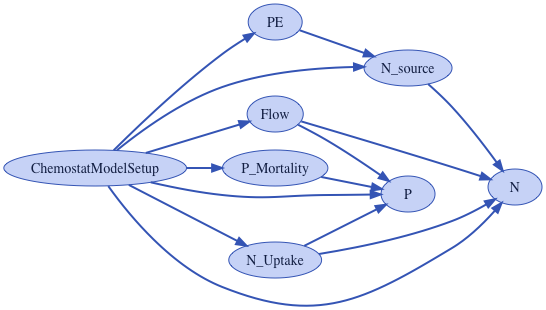

In [21]:
chemostat.visualize()

In [22]:
in_ds = xs.create_setup(
     model=chemostat,
     clocks={
         'time': np.linspace(0., 2., 10)
     },
     master_clock='time',
     input_vars={
         'ChemostatModelSetup':{
             # P params
             'P_num':10,
             'P_initVal':1,
             'halfsat_min':.2,
             'halfsat_max':1.2,
             'mortality':0.,
             # N params
             'N_initVal':1
         },
         # additional processes
         'Flow__flowrate':0.1,
         'N_source__nutrient_influx':0.5
     },
     output_vars={
        'P__state': 'time',
        'N__state': 'time'
     }
 )

In [23]:
from xsimlab.monitoring import ProgressBar

with ProgressBar(frontend='console'):
    with chemostat:
        out_ds = in_ds.xsimlab.run()

██████████ 100% | Simulation finished in 00:00 

[array([1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])]
2
2
2
2
2
2
2
2
2


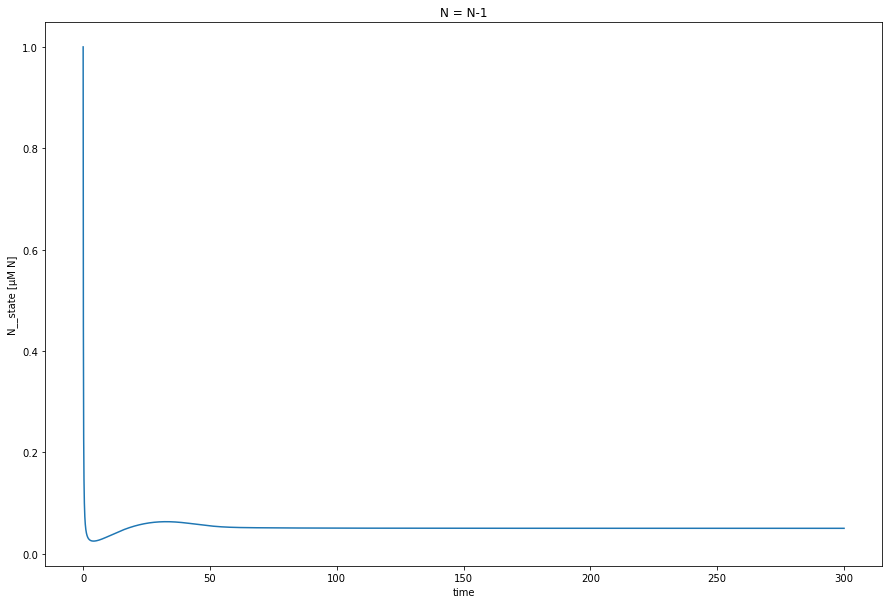

In [13]:
out_ds.N__state.plot()

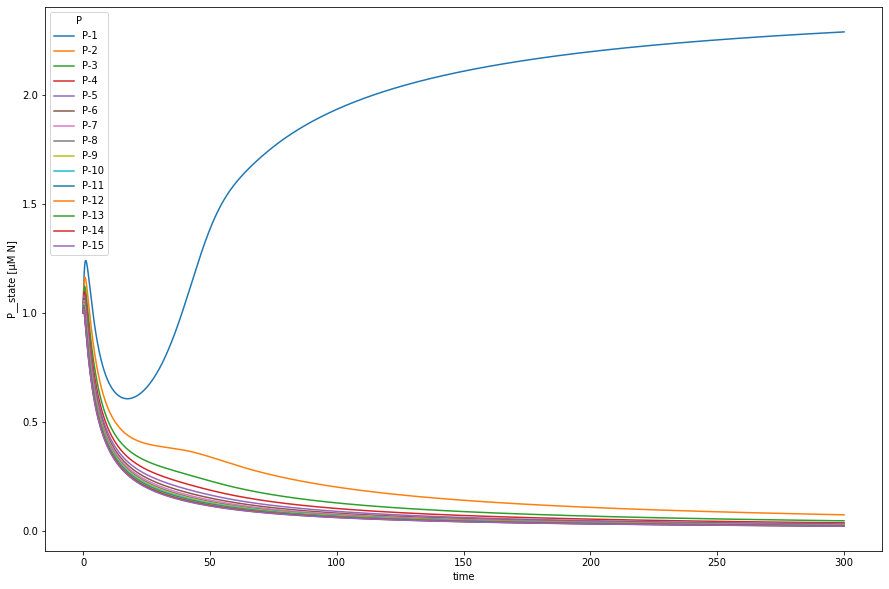

In [14]:
out_ds.P__state.plot.line(x='time')

# not suprisingly, one phytoplankton type wins out in the end, outcompeting all other types..
## predictably this is the type with the lowest half-saturation constant. 
(P-1 in this case, the halfsat parameter range is initialized in an increasing order)

This is unsurprising given the simple model structure and parameterization, but model results can be made much more interesting by including grazers and other pocesses that create further competition between phytoplankton types.

In [ ]:
@xs.process
class Flux:
    """ This defines a flux, that acts on one componment"""
    supply = xs.variable(
        dims='x',
        intent='out',
        groups=['x_flux'],
        description='sum of all x fluxes',
        attrs={'units': 'µM X d-1'}
    )

    X = xs.foreign(Component, 'state', intent='in')
    nutrient_influx = xs.variable(intent='in', groups='parameters', attrs={'units': 'µM N d-1'})
    


# Model Dummy Code

if i have a matrix of fluxes, for each PhysEnv, how could I build that up?
for each component, the flux can be computed via numpy array, vectorisation.

but the actual computation, should it happen in PhysEnv?

so that each component, only aggregates the fluxes that are applied, but the actual calcualtion and update of model state is in a numpy matrix in PhysEnv??



In [38]:
ident = np.identity(7)

ident_1 = ident[3:4,]

ident

array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.]])

In [81]:
components = np.array(['P','Z','D'])

In [75]:
np.array([[[1.,2.,3.], [4, 5, 6]], [[7, 8, 9], [10, 11, 12]]], dtype='float64')

array([[[ 1.,  2.,  3.],
        [ 4.,  5.,  6.]],

       [[ 7.,  8.,  9.],
        [10., 11., 12.]]])

In [76]:
state = np.array([[1.,2.,3.],[0.5,0.5,0],[1.,0,0]], dtype='float64')

In [77]:
state

array([[1. , 2. , 3. ],
       [0.5, 0.5, 0. ],
       [1. , 0. , 0. ]])

In [66]:
state[components=='D']

array([list([1])], dtype=object)

In [ ]:
np.unique(names)

In [80]:
# boolean checks like dis
samearr = ident.astype(np.float64)
samearr = samearr*3

ident[np.ix_([0,1])]

array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.]])

In [ ]:
## Fixed Dims
# Component 1D, 2D

#numpy notes:
# Nested sequences, like a list of equal-length lists, will be converted into a multidimensional array:
#np.zeros((3, 6)) <- np.shape
#np.arange for all self.num listcreations

#ones_like#ones_like#Produce an array of all 1’s with the given shape and dtype. ones_like takes another array and produces a ones array of the same shape and dtype. - useful

#eye#identity#Create a square N x N identity matrix (1’s on the diagonal and 0’s elsewhere)

#remeber, there is dtype='bool', which is perfect for ON/OFF switches in the model framework!

# slices are views! you can assign to them too! and it get's propagated .. this would be the way to go with splitting the environment according to fluxes! damn.. 


# OKAY major breakthrough, so the numpy matrix needs to have fixed dims, also down to the component level, number of types, etc. BUT this is no biggie, because I can use masked arrays/boolean checks easily 
# + this can be set in xsimlab at init phase



In [3]:
@xs.process
class Component:
    """
    Each component of the ecosystem represents a scalar or array of state variables that are defined by the same fluxes.
    Multiple state variables can encode different behaviour through parameters, that are kept as arrays of the same dimension as the component.
    """
    num = xs.variable(dims=(),intent='in', description='number of this component (i.e. number of state variables)')
    
    # maximum dimension of all Components is calculated in ModelSetup, and passed to each component, to initialize regular matrix   
    fxpars = xs.variable(groups='forcingpars', intent='in')
    
    label = xs.variable(intent='out', groups='label')
    state = xs.variable(intent='inout', groups='state')

@xs.process
class Nutrient(Component):
    """
    The Nutrient component so far only supports one instance, however more nutrients could be added, by instantiating multiple Nutrient components. (This also makes more ecological sense.)
    """
    N = xs.index(dims='N')
    component_label = xs.variable(default='N', groups='component-label', static=True) 

    fluxes = xs.group('n_flux')
    state = xs.variable(dims='N', intent='inout', groups='state', description='component array', attrs={'units': 'µM N'})

    # PARAMETERS / INPUTS
    #num = xs.variable(default=1, static=True, description='number of nutrients (1 by default)')
    
    def initialize(self):
        self.time = 0
        self.N = np.array([f"{self.component_label}-{i+1}" for i in range(self.num)])
        self.label = self.N
            
@xs.process
class Phytoplankton(Component):
    """
    The Phytoplankton component allows for multiple state variables to be instatiated along the 'P' dimension.
    The parameter 'halfsat' is initialized in the ModelSetup process, and describes the half-saturation constant of nutrient uptake for each Phytoplankton state variable along dimension 'P'. 
    (Note: in this simplified model nutrient uptake = growth, also described as the Monod equation. Any ingested nutrient is directly converted to biomass.)
    
    Parameters are stored in arrays the same dimensionality as the states, so that each "Phytoplankton" can have a different parameterization. The initialisation of the parameter arrays is handled in the ModelSetup class.
    """
    P = xs.index(dims='P')
    component_label = xs.variable(default='P', groups='component-label', static=True)
    
    fluxes = xs.group('p_flux')
    state = xs.variable(dims='P', intent='inout', groups='state', description='component array', attrs={'units': 'µM N'}) # get this from ModelSetup
    
    # PARAMETERS / INPUTS (would come from ModelSetup)
    # halfsat = xs.variable(intent='in', dims='P', groups='parameters', attrs={'units': 'µM N'})
    # mortality = xs.variable(intent='in', dims='P', groups='parameters', attrs={'units': 'd-1'})
    
    def initialize(self):
        self.time = 0
        self.P = np.array([f"{self.component_label}-{i+1}" for i in range(self.num)])
        self.label = self.P
        
@xs.process
class Zooplankton(Component):
    """
    The Zooplankton component allows for multiple state variables to be instatiated along the 'Z' dimension.

    """
    Z = xs.index(dims='Z')
    component_label = xs.variable(default='Z', groups='component-label', static=True)

    
    fluxes = xs.group('z_flux')
    state = xs.variable(dims='Z', intent='inout', groups='state', description='component array', attrs={'units': 'µM N'}) # get this from ModelSetup

    def initialize(self):
        self.time = 0
        self.Z = np.array([f"{self.component_label}-{i+1}" for i in range(self.num)])
        self.label = self.Z

In [4]:
@xs.process
class LinearGrowth:
    """
    Linear growth rate of NPZ components
    """
    rateN = xs.variable(
        dims='N',
        intent='out',
        groups=['n_flux'],
        #description='phytoplankton growth, under light & nutrient limitation',
        attrs={'units': 'µM N d-1'}
    )
    rateP = xs.variable(
        dims='P',
        intent='out',
        groups=['p_flux'],
        description='phytoplankton growth, under light & nutrient limitation',
        attrs={'units': 'µM N d-1'}
    )
    rateZ = xs.variable(
        dims='Z',
        intent='out',
        groups=['z_flux'],
        #description='phytoplankton growth, under light & nutrient limitation',
        attrs={'units': 'µM N d-1'}
    )
    
    lineargrowth = xs.variable(intent='in')
    
    N = xs.foreign(Nutrient, 'state', intent='in')
    P = xs.foreign(Phytoplankton, 'state', intent='in')
    Z = xs.foreign(Zooplankton, 'state', intent='in')
    
    def run_step(self):
        self.rateN = self.lineargrowth * self.N
        self.rateP = self.lineargrowth * self.P
        self.rateZ = self.lineargrowth * self.Z

In [5]:
@xs.process
class PhysEnv:
    """This collects all fluxes and components and does matrix-wise updating of their states then"""
    std_forcingpars = xs.variable(intent='in')  # dims=('envs','comps','types'), 
    
    ind_forcingpars = xs.group('forcingpars')
    
    #components = xs.group('component')
    labels = xs.group('label')
    states = xs.group('state')
    
    maxdim = xs.variable(intent='in')
    
    forcingpars = xs.variable(intent='out')

    def initialize(self):
        print('ind_forcing',list(self.ind_forcingpars))
        print('std_forcing',self.std_forcingpars)
        #cond = list(self.ind_forcingpars) > list(self.std_forcingpars)
        #print('cond',cond)
        self.forcingpars = [0] #np.where(cond, self.ind_forcingpars, self.std_forcingpars)
        print('self.labels',list(self.labels))
        print('self.states',list(self.states))
        
    def run_step(self):
        print(list(self.forcingpars))


# ideally:
@xs.process
class Grid1D:
    """This collects all PhysEnv and does matrix-wise updating of their states according to Exchange Processes"""
    num_envs = xs.group('Environment')
    num_comps = xs.group('Component')
    num_types = xs.group('Type')
    
    #grid = xs.variable(dims=('envs','comps','types'), intent='inout')
    
@xs.process
class ModelSetup:
    N_num = xs.variable(intent='in')
    P_num = xs.variable(intent='in')
    Z_num = xs.variable(intent='in')
    
    std_fxpars = xs.variable(intent='in')
    
    lineargrowth = xs.foreign(LinearGrowth, 'lineargrowth', intent='out')
    
    maxdim = xs.foreign(PhysEnv, 'maxdim', intent='out')
    
    std_forcingpars = xs.foreign(PhysEnv, 'std_forcingpars', intent='out')
    
    Nnum = xs.foreign(Nutrient,'num', intent='out')
    Pnum = xs.foreign(Phytoplankton,'num', intent='out')
    Znum = xs.foreign(Zooplankton,'num', intent='out')
    
    Nstate= xs.foreign(Nutrient,'state', intent='out')
    Pstate = xs.foreign(Phytoplankton,'state', intent='out')
    Zstate = xs.foreign(Zooplankton,'state', intent='out')
    
    

    def initialize(self):
     
        self.lineargrowth = 0.1
        
        self.Nnum = self.N_num
        self.Pnum = self.P_num
        self.Znum = self.Z_num   
        self.maxdim = np.max(np.array([self.N_num,self.P_num,self.Z_num], dtype='int64'))
        
        self.Nstate = np.array([0.1 for i in range(self.N_num)], dtype='float64')
        self.Pstate = np.array([0.1 for i in range(self.P_num)], dtype='float64')
        self.Zstate = np.array([0.1 for i in range(self.Z_num)], dtype='float64')
        
        self.std_forcingpars = np.array([self.std_fxpars for i in range(self.maxdim)], dtype='float64')
       
        
        
        
        

In [12]:
testcase = xs.Model(
    {
        # Grid
        '1D':Grid1D,
        # PhysEnv
        'PE':PhysEnv,
        # model setup
        'MS':ModelSetup,
        # components
        'Nuts':Nutrient, 
        'Phyto':Phytoplankton, 
        'Zoo':Zooplankton, 
        # flows
        'Flx':LinearGrowth
    }
)

In [13]:
testcase

<xsimlab.Model (7 processes, 10 inputs)>
1D
MS
    Z_num               [in]
    P_num               [in]
    N_num               [in]
    std_fxpars          [in]
Flx
Nuts
    fxpars              [in]
    component_label     [in]
Zoo
    fxpars              [in]
    component_label     [in]
Phyto
    fxpars              [in]
    component_label     [in]
PE

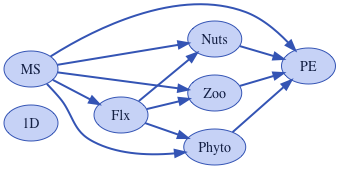

In [14]:
testcase.visualize()

In [15]:
x2_ds = xs.create_setup(
     model=testcase,
     clocks={
         'time': np.linspace(0., 2., 10)
     },
     master_clock='time',
     input_vars={
         'MS':{
             # P params
             'P_num':10,
             'Z_num':10,
             'N_num':10,
             'std_fxpars':0.2
             
         },
         'Nuts__fxpars':0.1,
         'Phyto__fxpars':0.1,
         'Zoo__fxpars':0.3
         
     },
     output_vars={
        'Nuts__state': 'time',
        'Phyto__state': 'time',
        'Zoo__state': 'time'
     }
 )

In [16]:
from xsimlab.monitoring import ProgressBar

with ProgressBar(frontend='console'):
    with testcase:
        x2_ds_out = x2_ds.xsimlab.run()


             0% | initialize 
▉            9% | run step 0/9 
█▊          18% | run step 1/9 
██▋         27% | run step 2/9 
███▋        36% | run step 3/9 
████▌       45% | run step 4/9 
█████▍      55% | run step 5/9 
██████▎     64% | run step 6/9 
███████▎    73% | run step 7/9 
████████▏   82% | run step 8/9 
█████████   91% | finalize     
██████████ 100% | Simulation finished in 00:00 

ind_forcing [0.1, 0.3, 0.1]
std_forcing [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
self.labels [array(['N-1', 'N-2', 'N-3', 'N-4', 'N-5', 'N-6', 'N-7', 'N-8', 'N-9',
       'N-10'], dtype='<U4'), array(['Z-1', 'Z-2', 'Z-3', 'Z-4', 'Z-5', 'Z-6', 'Z-7', 'Z-8', 'Z-9',
       'Z-10'], dtype='<U4'), array(['P-1', 'P-2', 'P-3', 'P-4', 'P-5', 'P-6', 'P-7', 'P-8', 'P-9',
       'P-10'], dtype='<U4')]
self.states [array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]), array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]), array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


In [204]:
np.zeros(3)

array([0., 0., 0.])

quick test with dims, and how they get aggregated in xsimlab

In [243]:
@xs.process
class InitStates:
    """Flat initial profile of `u`."""

    #states = xs.foreign(Component, 'state', intent='out')
    #lables = xs.foreign(Component, 'label', intent='out')
    #EcoDim = xs.foreign(PhysEnv, 'EcoDim')

    #def initialize(self):
    #    self.states = np.zeros_like(self.EcoDim)
    #    self.lables = np.zeros_like(self.EcoDim)

@xs.process
class PhysEnv:
    dimnum = xs.variable(intent='out')
    econum = xs.variable(intent='out')
    
    EcoDim = xs.index(dims='EcoDim')
    EcoNum = xs.index(dims='EcoNum')
    
    dimnums = xs.group('dimnum')
    #dimlabels = xs.group('label')
    #dimstates = xs.group('state')
    
    Ecosys = xs.variable(dims=('EcoDim','EcoNum'), intent='out')
    
    def initialize(self):
        self.dimnum = max(x for x in self.dimnums)
        self.econum = len(list(self.dimnums))
        print(self.dimnum)
        print(self.econum)
        self.EcoDim = np.array([f"{'EcoType'}-{i+1}" for i in range(self.dimnum)])
        self.EcoNum = np.array([f"{'Eco'}-{i+1}" for i in range(self.econum)])
        print(self.EcoDim)
        print(self.EcoNum)
        
        self.Ecosys = np.zeros((self.econum,self.dimnum))
        print(self.Ecosys)
        
    def run_step(self):
        print(self.Ecosys)

@xs.process
class Component:
    num = xs.variable(intent='in', groups='dimnum')
    
    #dimnum = xs.foreign(PhysEnv,'dimnum')
    
    
    label = xs.variable(dims='EcoDim', intent='inout', groups='label')
    state = xs.variable(dims='EcoDim', intent='inout', groups='state')
    
    initVal = xs.variable(default=1)
    
    
    def initialize(self):
        #self.label = np.zeros(self.dimnum, dtype='<U4')
        #self.state = np.zeros(self.dimnum)
        print('zeros',self.label)
        print('zeros',self.state)
        self.label[:self.num] = [f"{self.component_label}-{i+1}" for i in range(self.num)]
        self.state[:self.num] = [self.initVal for i in range(self.num)] #assign input states
        print('label',self.label)
        print('state',self.state)
        
    def run_step(self):
        #print(self.state)
        self.state = self.state*0.1
    
    
@xs.process
class Nutrient(Component):
    component_label = xs.variable(default='N', groups='ComponentLabel')
    comps = xs.group('ComponentLabel')
     
@xs.process
class Phytoplankton(Component):
    component_label = xs.variable(default='P')
    
@xs.process
class Zooplankton(Component):
    component_label = xs.variable(default='Z')

In [244]:
DimsMod = xs.Model({'N':Nutrient, 'P1':Phytoplankton, 'Z':Zooplankton,'P2':Phytoplankton, 'PE':PhysEnv, 'IS':InitStates})

In [245]:
DimsMod_ds = xs.create_setup(
    model=DimsMod,
    clocks={
         'time': np.linspace(0., 2., 10)
    },
    master_clock='time',
    input_vars={
        'N__num':5,
        'P1__num':7,
        'P2__num':4,
        'Z__num':14
        
    },
    output_vars={
       'N__state': 'time',
       'P1__state': 'time',
       'P2__state': 'time',
       'Z__state': 'time'
    }
)

In [246]:
with DimsMod:
    out = DimsMod_ds.xsimlab.run()

KeyError: "Missing variables ['Z__label', 'N__label', 'P1__state', 'P2__state', 'P1__label', 'P2__label', 'N__state', 'Z__state'] in Dataset"

In [142]:
out

<xarray.Dataset>
Dimensions:    (time: 10, x: 7, x1: 5, x2: 7)
Coordinates:
  * time       (time) float64 0.0 0.2222 0.4444 0.6667 ... 1.333 1.556 1.778 2.0
  * x          (x) <U3 'x-1' 'x-2' 'x-3' 'x-4' 'x-5' 'x-6' 'x-7'
  * x1         (x1) <U4 'x1-1' 'x1-2' 'x1-3' 'x1-4' 'x1-5'
  * x2         (x2) <U4 'x2-1' 'x2-2' 'x2-3' 'x2-4' 'x2-5' 'x2-6' 'x2-7'
Data variables:
    T1__num    int64 5
    T1__state  (time, x1) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    T2__num    int64 7
    T2__state  (time, x2) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1

# Notes Fri Eve:

- so current question is how to best create PhysEnv matrix of all components
it needs to be flat, in a sense, and I will have to do some padding at some point

it actually makes sense I think to pass it through as lists
and then make it a matrix (numpy) only in PhysEnv! 

TODO:
- get multiple components into multidimensional list in above ModDims model
- create matrix from this, with reasonable padding

- create phys env forcing that affects all of them
and accumulate all other fluxes, as group from components, like P_flux and N_flux are the same group


In [60]:
@xs.process
class InitStates:
    """Flat initial profile of `u`."""
    pass
    #states = xs.foreign(Component, 'state', intent='out')
    #lables = xs.foreign(Component, 'label', intent='out')
    #EcoDim = xs.foreign(PhysEnv, 'EcoDim')

    #def initialize(self):
    #    self.states = np.zeros_like(self.EcoDim)
    #    self.lables = np.zeros_like(self.EcoDim)

@xs.process
class PhysEnv:
    dimnum = xs.foreign(Component, 'label', intent='out')
    #econum = xs.variable(intent='out')
    
    EcoDim = xs.index(dims='EcoDim')
    EcoNum = xs.index(dims='EcoNum')
    
    #dimlabels = xs.group('label')
    #dimstates = xs.group('state')
    
    Ecosys = xs.variable( intent='out') # dims=('EcoDim','EcoNum'),
    
    def initialize(self):
        print('PhysEnv - init')
        print(self.dimnum)
        #print(self.econum)
        #self.EcoDim = np.array([f"{'EcoType'}-{i+1}" for i in range(self.dimnum)])
        #self.EcoNum = np.array([f"{'Eco'}-{i+1}" for i in range(self.econum)])
        #print(self.EcoDim)
        #print(self.EcoNum)
        
        self.Ecosys = 0 #np.zeros((self.econum,self.dimnum))
        #print(self.Ecosys)
        
@xs.process
class Component:
    num = xs.variable(intent='in', groups='dimnum')
    
    #dimnum = xs.foreign(PhysEnv,'dimnum')
    dimnums = xs.group('dimnum')
    x = xs.index(dims='x')
    
    label = xs.variable(dims='x', intent='out', groups='label')
    state = xs.variable(dims='x', intent='out', groups='state')
    
    initVal = xs.variable(default=1)
    
    
    def initialize(self):
        print('hi')
        self.x = max(x for x in self.dimnums)
        print(list(self.dimnums))
        print(self.x)
        self.label = np.array([f"{self.component_label}-{i+1}" for i in range(self.num)])
        self.state = np.array([self.initVal for i in range(self.num)]) #assign input states

        
    def run_step(self):
        print(self.state)
    
    
@xs.process
class Nutrient(Component):
    component_label = xs.variable(default='N', groups='ComponentLabel')
     
@xs.process
class Phytoplankton(Component):
    component_label = xs.variable(default='P', groups='ComponentLabel')
    
@xs.process
class Zooplankton(Component):
    component_label = xs.variable(default='Z', groups='ComponentLabel')

ValueError: Conflict between foreign variable 'dimnum' and its target variable 'Component.label', both have intent='out'.

In [ ]:
np.arange()

@xs.process
class Dimensionality:
    type_labels = xs.group('type_label')
    component_labels = xs.group('component_label')
    env_labels = xs.group('env_label')
    envs_labels = xs.group('envs_label')
    
    type_states = xs.group('type_state')
    #component_states = xs.group('component_state')
    #env_states = xs.group('env_state')
    
    dim0 = xs.index(dims='dim0')
    dim1 = xs.index(dims='dim1')
    dim2 = xs.index(dims='dim2')
    dim3 = xs.index(dims='dim3')
    
    def initialize(self):
        print(list(self.type_states))
        
        dimnum0 = len(max(list(self.type_labels)))
        dimnum1 = len(max(list(self.component_labels)))
        dimnum2 = len(max(list(self.env_labels)))
        dimnum3 = len(max(list(self.envs_labels)))
        
        econum0 = len(list(self.type_labels))
        econum1 = len(list(self.component_labels))
        econum2 = len(list(self.env_labels))
        econum3 = len(list(self.envs_labels))
        
        print(dimnum0)
        print(dimnum1)
        print(dimnum2)
        print(dimnum3)
        
        print(econum0)
        print(econum1)
        print(econum2)
        print(econum3)
        self.dim0 = np.arange(dimnum0)
        self.dim1 = np.arange(dimnum1)
        self.dim2 = np.arange(dimnum2)
        self.dim3 = np.arange(dimnum3)
    
    

In [220]:
@xs.process
class PhysicalEnvironment:
    type_labels = xs.group('type_label')
    component_labels = xs.group('component_label')
    
    components_dim = xs.variable(intent='out')
    types_dim = xs.variable(intent='out')
    
    components_num = xs.variable(intent='out')
    types_num = xs.variable(intent='out')
    
    envs_label = xs.variable(intent='out', groups='envs_label')
    env_label = xs.variable(intent='in', groups='env_label')
    
    num = xs.variable(intent='in')
    
    physenv = xs.variable(intent='out', group='physenv')
    
    def initialize(self):
        §THERES AN ISSUE WITH HOW THE DIMS ARE CALCULATED
        self.components_dim = len(max(list(self.type_labels)))
        self.types_dim = len(max(list(self.component_labels)))
        
        self.components_num = len(list(self.type_labels))
        self.types_num = len(list(self.component_labels))
        
        print('c_dim',self.components_dim)
        print('t_dim',self.types_dim)
        print('c_num',self.components_num)
        print('t_num',self.types_num)
        self.physenv = np.zeros((self.types_num ,self.types_dim,self.components_num, self.components_dim)))
        
        self.envs_label = [f"{self.env_label}-{i+1}" for i in range(self.num)]
        print(self.envs_label)
    

@xs.process
class Component:
    type_label = xs.variable(intent='out', groups='type_label')
    type_state = xs.variable(intent='out', groups='type_state')
    
    # specific label must be supplied to component instance at model runtime
    component_label = xs.variable(intent='in', groups='component_label')
    
    num = xs.variable(intent='in')
    
    def initialize(self):
        self.type_label = [f"{self.component_label}-{i+1}" for i in range(self.num)]
        
        self.type_state = [1 for i in range(self.num)]
    
    

# what is the actual dimensionality?

i have components, that conatin multiple types

and physenvs that contain multiple components

and multiple physenvs, that can interact


types=dim0
components=dim1
physenvs=dim2

In [221]:
DimsMod = xs.Model({'PE':PhysicalEnvironment, 'C1':Component, 'C2':Component, 'C3':Component})

In [222]:
DimsMod_ds = xs.create_setup(
    model=DimsMod,
    clocks={
         'time': np.linspace(0., 2., 10)
    },
    master_clock='time',
    input_vars={
        'C1__num':5,
        'C1__component_label':'c1',
        'C2__num':6,
        'C2__component_label':'c2',
        'C3__num':16,
        'C3__component_label':'c3',
        'PE__num':1,
        'PE__env_label':'env1'
        
    },
    output_vars={
  
    }
)

In [223]:
with DimsMod:
    out = DimsMod_ds.xsimlab.run()

c_dim 16
t_dim 2
c_num 3
t_num 3
[[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

In [146]:
out

<xarray.Dataset>
Dimensions:              (dim0: 16, dim1: 2, dim2: 4, time: 10)
Coordinates:
  * dim0                 (dim0) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * dim1                 (dim1) int64 0 1
  * dim2                 (dim2) int64 0 1 2 3
  * time                 (time) float64 0.0 0.2222 0.4444 ... 1.556 1.778 2.0
Data variables:
    C1__component_label  <U2 'c1'
    C1__num              int64 5
    C2__component_label  <U2 'c2'
    C2__num              int64 6
    C3__component_label  <U2 'c3'
    C3__num              int64 16
    PE__env_label        <U4 'env1'

# so what is working:

i can initialize multiple components, but no dims on them!..